### Human In The Loop
Human-in-the-loop means bringing humans into the decision-making process of an AI system whenever full automation is not reliable or desirable.  
Instead of letting the LLM or workflow completely decide, we allow a human operator to review, approve, or correct outputs at certain steps.  

This is crucial in workflows where:  
- The stakes are high (finance, healthcare, law).
- The model’s accuracy is uncertain.
- You need compliance checks or approvals.

##### How does LangGraph support HITL?
LangGraph is designed around state machines + nodes.  

Each node can represent:
- an LLM agent (automated)
- a tool (API call, database fetch)
- or a human node (pause for review).   

LangGraph supports HITL by:
1. Pausing execution at a step.
2. Requesting human input (e.g., approval, correction).
3. Resuming execution with the human feedback injected into the graph state.  

So, the workflow is partly automated, partly supervised.  

Langgraph has multiple options to pause the execution, like - interrupt_before["node_name"], interrupt_after["node_name"], which can be used when compiling the graph/workflow.

##### Why is HITL important in LangGraph?
- It increases trust in AI workflows.
- Provides a safety net when AI is uncertain.
- Enables progressive automation → start with heavy human oversight, reduce as AI improves.
- Prevents wrong or unsafe actions by models
- Allows seamless integration of manual oversight into autonomous flows
- Easy to resume workflows asynchronously (no need to restart)
- Enables traceability — you can store checkpoints and human decisions for audit

In [25]:
# Imports
from typing import Annotated, List
import operator
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
import os

In [2]:
# Load LLM
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
api_key = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(name="gpt-5-nano", api_key=api_key)
llm.invoke("What is machine learning?")

AIMessage(content='Machine learning is a subset of artificial intelligence that focuses on developing algorithms and statistical models that allow computers to learn from and make decisions or predictions based on data without being explicitly programmed. Machine learning algorithms are designed to recognize patterns and make insights from large sets of data, and can be used in a variety of applications such as image and speech recognition, natural language processing, and predictive analytics.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 12, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Caj7uCjFixgdwDM093k3FBz8ryloq', 'service_tier': 'default', 'finish_reason'

In [19]:
# Custom tool
from langchain.tools import tool

def multiply(a: int, b: int) -> int:
    """Multiply two numbers - a and b
    Args:
        a: first number
        b: second number
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers - a and b.
    Parameters
    ----------
    a : int
        The first number.
    b : int
        The second number.

    Returns
    -------
    int
        The sum of the given numbers.
    """
    return a + b

def divide(a: int, b: int) -> int:
    """Divide two numbers - a and b
    Args:
        a: first number
        b: second number
    """
    return a / b

tools = [add, multiply, divide]

In [20]:
# Integrate custom tools with LLM
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(name='gpt-5-nano', client=<openai.resources.chat.completions.completions.Completions object at 0x000002305B5D7520>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002305BB113F0>, root_client=<openai.OpenAI object at 0x000002305B5D7400>, root_async_client=<openai.AsyncOpenAI object at 0x000002305BB11360>, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add two numbers - a and b.\nParameters\n----------\na : int\n    The first number.\nb : int\n    The second number. Returns\n-------\nint\n    The sum of the given numbers.', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply two numbers - a and b\nArgs:\n    a: first number\n    b: second number', 'parameters': {'pro

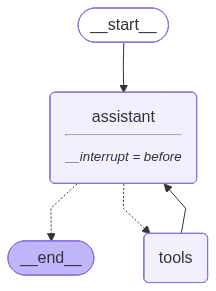

In [29]:
# Workflow

system_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic operations on set of inputs.")

# Nodes definition
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    )
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["assistant"])

# View graph
graph_image = graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [31]:
thread = {"configurable": {"thread_id": "123"}}
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

In [32]:
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
# Execution stopped at assistant node
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='29d1f437-3c19-4032-a2e4-76fd2f381ab0')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0bfd38-7cb3-67c2-8000-b7aeff11e99f'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-12T14:26:08.573229+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0bfd38-7cae-69d2-bfff-dcd48f9aea96'}}, tasks=(PregelTask(id='4ca117ec-f2c7-c82d-71d4-084d2341eb86', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [35]:
# to continue execution, do not provide the initial input
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TYC2SNOauj6dsFPFsGpwpeIv)
 Call ID: call_TYC2SNOauj6dsFPFsGpwpeIv
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [38]:
# Execution stopped again at assistant after the tool gives the response
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='29d1f437-3c19-4032-a2e4-76fd2f381ab0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TYC2SNOauj6dsFPFsGpwpeIv', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 194, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cb6Krlydf4yYL5QExiYDqzRpX40V4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bba0d94a-94dd-4ce1-83ae-b0eb99a5f2e5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_TYC2SNOauj6dsFPFs

In [39]:
# to continue execution further to END, do not provide the initial input
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [41]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='29d1f437-3c19-4032-a2e4-76fd2f381ab0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TYC2SNOauj6dsFPFsGpwpeIv', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 194, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cb6Krlydf4yYL5QExiYDqzRpX40V4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bba0d94a-94dd-4ce1-83ae-b0eb99a5f2e5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_TYC2SNOauj6dsFPFs

## Edit Human Feedback
Here, we are trying to modify the prompt using `update_state`

In [56]:
thread = {"configurable": {"thread_id": "123"}}
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [57]:
graph.update_state(thread, {"messages": [HumanMessage(content="No, please multiple 15 and 6")]})

{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bfe08-bbf7-6877-800c-3438b613a318'}}

In [58]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='29d1f437-3c19-4032-a2e4-76fd2f381ab0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TYC2SNOauj6dsFPFsGpwpeIv', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 194, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cb6Krlydf4yYL5QExiYDqzRpX40V4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bba0d94a-94dd-4ce1-83ae-b0eb99a5f2e5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_TYC2SNOauj6dsFPFs

In [59]:
new_state = graph.get_state(thread).values
for message in new_state['messages']:
    message.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TYC2SNOauj6dsFPFsGpwpeIv)
 Call ID: call_TYC2SNOauj6dsFPFsGpwpeIv
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, please multiple 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wrtyvEVzwkdky5Be7qNCTSFa)
 Call ID: call_wrtyvEVzwkdky5Be7qNCTSFa
  Args:
    a: 15
    b: 6
================================= Tool Message ==================

In [60]:
# to continue execution further to END, do not provide the initial input
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, please multiple 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_91mnnL10MZcLbvrs0CvJoNVF)
 Call ID: call_91mnnL10MZcLbvrs0CvJoNVF
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [61]:
# to continue execution further to END, do not provide the initial input
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

The result of multiplying 15 and 6 is 90.


## Workflow will wait for the user input

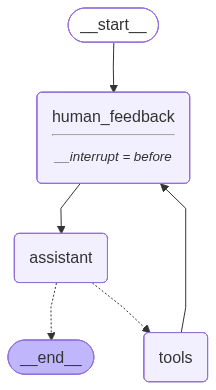

In [62]:
# System message
system_message = SystemMessage(content="You are a helpful assistant with performing arithmatic operations on a set of inputs.")

# Nodes
def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message] + state['messages'])]}

# Graph
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    )
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

# View graph
graph_image = graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [65]:
# Input
initial_input = {"messages": "Multiply 5 and 7"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Tell me how you want to update the state: ")
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================ Human Message =================================

No, add 5 and 7
================================== Ai Message ==================================
Tool Calls:
  add (call_z8oB7ywbhSQWj9uJC3QABzd7)
 Call ID: call_z8oB7ywbhSQWj9uJC3QABzd7
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12


In [66]:
# Continue the execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

12
================================== Ai Message ==================================

The addition of 5 and 7 is 12.
